# Single snapshot spatial-association of range-doppler observations from a linear sensor array
__Single snapshot imaging__ provides timely situational awareness, but can utilize neither platform motion, as in synthetic aperture radar, nor track targets across time, as in Kalman filtering and its variants. Associating measurements with targets becomes a fundamental bottleneck in this setting.

This notebook illustrates a computationally efficient method for spatial association of single set of unordered range-doppler measurements from  a network of radar sensors. 

The 2D position and velocity of multiple targets are estimated using a linear array of FMCW radar sensors by identifying and exploiting inherent geometric features to drastically reduce the
complexity of spatial association. The algorithm is robust to detection anomalies at sensors and achieves order of magnitude lower complexity compared to conventional methods.

More details can be found in our paper: 

---
A. Gupta, A. D. Sezer and U. Madhow, "[Multi-Sensor Spatial Association Using Joint Range-Doppler Features](https://ieeexplore.ieee.org/abstract/document/9568701)," in IEEE Transactions on Signal Processing, vol. 69, pp. 5756-5769, 2021, doi: 10.1109/TSP.2021.3119418.

---

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
from time import perf_counter

# Custom libs
import GAutils.objects as ob
import GAutils.config as cfg # Sim parameters
import GAutils.proc_est as pr
import GAutils.simulate_snapshot2 as sim2
import GAutils.perf_eval as prfe
import GAutils.PCRLB as pcrlb
import GAutils.ml_est as mle
import GAutils.gradient_methods as gm
import GAutils.graph_primitives as grpr
import GAutils.est_algo as ea

### Simulation params

In [19]:
assoc_algo = 'SAGA' #Proposed 'SAGA', Brute force 'SAESL'
rob = 1 # Robustness level, rho
estalgo = 2 #0:DFT (conventional), 1:oversampled DFT, 2:NOMP (proposed super-resolution algo)
Nob = 20 # Number of point targets in the scene
Nsens = 4 # Number of sensors
swidth = 2 # Width of sensor array in m
snr = -10 # SNR of FMCW radar sensor beat signal
pmiss = 0.1 # Miss probability at each sensor
osps = [3,3] # Oversampling factor for DFT est algo, >2 is sufficient

# Generate linear array of sensors along x axis
sx = np.linspace(-swidth/2, swidth/2,Nsens)
sensors = [ob.Sensor(x,0) for x in sx]
seed = np.random.randint(1000, size=1)
scene = pr.init_random_scene(Nob, sensors, cfg.sep_th, seed)
cfgp = {'Nsel': [],# Genie info on # targets
            'rd_wt':cfg.rd_wt,
            'static_snapshot': cfg.static_snapshot,
            'sep_th':cfg.sep_th,
            'pmiss':pmiss,
            'estalgo':estalgo, 
            'osps':cfg.osps,
            'n_Rc':cfg.n_Rc,
            'n_pfa':cfg.n_pfa,
            # Association
            'rob':rob,
            'mode': cfg.mode,
            'hscale':cfg.hscale,
            'incr':cfg.incr,
            'hN': cfg.hN,
            'ag_pfa':cfg.ag_pfa,
            'al_pfa':cfg.al_pfa,
            'Tlen':cfg.Tlen,
            # Gauss Newton
            'gn_steps':cfg.gn_steps,
            'fu_alg':cfg.fu_alg
            }

### Generate Range, doppler data for linear arrays of sensors

In [20]:
tf_list = np.array([sensor.mcs.tf for sensor in sensors])  # FMCW radar pulse time equal for all sensors
tfa_list = np.array([sensor.mcs.get_tfa() for sensor in sensors])  # Adjust so that samples vary to keep frame time const.

beat = np.zeros(tfa_list.shape, dtype='complex128') #Intialize FMCW sensor beat signal
dt = 0 # time between frames = 0:Static, tf_list[0]:moving 
signal_mag =1 # Normalized signal amplitude
for sensor in sensors:
    sensor.meas_std = 10 **(-snr/20)*signal_mag

gardas = [ob.gardEst() for sensor in enumerate(sensors)]
targets_list = []
#Genie range, doppler, signal amplitude obs
for tno, target in enumerate(scene):
    [next_target, AbsPos] = pr.ProcDyms(target, dt, tfa_list)# abs position over obs time
    for sensorID, sensor in enumerate(sensors):
        random_number = np.random.rand()
        if random_number>pmiss: #Miss target otherwise
            pure_beat = pr.get_beat(sensor, target, AbsPos[sensorID])
            beat[sensorID, :, :] += pure_beat # Add beat signal for each target
        garda = pr.get_gard_true(sensor, target) 
        gardas[sensorID].r=np.append(gardas[sensorID].r,garda.r)
        gardas[sensorID].d=np.append(gardas[sensorID].d,garda.d)
        gardas[sensorID].g=np.append(gardas[sensorID].g,garda.g)
# Add noise to sensor beat signal
np.random.seed(seed) # To randomize over parallel runs
for sensorID, sensor in enumerate(sensors):
    beat[sensorID, :, :] = pr.add_cnoise(beat[sensorID, :, :], sensor.meas_std) 
#        print('Target{}: x={},y={},vx={},vy={}'.format(tno, target_current.x, target_current.y,target_current.vx,

## Radar processing: 
Estimate Range-doppler from FMCW beat signal using estalgo={0,1,2}
* 0. DFT
* 1. Oversampled DFT
* 2. NOMP, Super-resolution algorithm

In [21]:
runtime = np.zeros(3)
t=perf_counter()
if estalgo == 0:
    garda_sel = ea.meth2(np.copy(beat), sensors, cfgp['Nsel'], [1,1])
elif estalgo == 1:
    garda_sel = ea.meth2(np.copy(beat), sensors, cfgp['Nsel'], cfgp['osps'], cfgp['n_pfa'])
elif estalgo == 2:
    garda_sel = ea.nomp(np.copy(beat), sensors, cfgp['Nsel'], cfgp['osps'], cfgp['n_Rc'], cfgp['n_pfa'])
runtime[0] = perf_counter() - t

rd_error = prfe.compute_rd_error(garda_sel, gardas)
rde_pack = prfe.compute_rde_targetwise(garda_sel, gardas, sensors)

### Perform spatial association across sensors and estimate position, velocity

In [22]:
 #%% Graph Algo
t=perf_counter()
G1, Total_edges = grpr.make_graph(garda_sel, sensors, 0) 
if assoc_algo=='MCF':
    min_gsigs, glen, assoc_time = mcft.get_mcfsigs(garda_sel, sensors, cfgp)
elif assoc_algo=='mcf_all':
    min_gsigs, glen, assoc_time = mcft.get_mcfsigs_all(garda_sel, sensors, cfgp)
elif assoc_algo=='SAESL':
    min_gsigs, glen, assoc_time = mle.iterative_prune_pht(garda_sel, sensors, cfgp, sum(len(g.r) for g in garda_sel)//2)
elif assoc_algo=='SAGA':
    min_gsigs, glen, assoc_time = grpr.get_minpaths(G1, sensors, cfgp['mode'], cfgp)
else:
    print('Invalid association algorithm')
runtime[1] = perf_counter() - t # Total time (Make graph + graph association)
Pruned_edges = sum([len(nd.lkf) for g in G1 for nd in g]) # No of edges, get V from glen

Refine position, velocity estimate

In [23]:
t = perf_counter()
for sig in min_gsigs:
    [dob, nlls_var] = gm.gauss_newton(sig, sensors, sig.state_end.mean , cfgp['gn_steps'], cfgp['rd_wt'])#lm_refine, gauss_newton, huber
    sig.state_end.mean = dob
runtime[2] = perf_counter() - t # Time to Refine
gr_centers = []
for gtr in min_gsigs:
    dob = gtr.state_end.mean
    gr_centers.append(ob.PointTarget(dob[0], dob[1], dob[2], dob[3]))

In [24]:
#Plot likelihood maps
# [xgrid, ygrid, llr_map] = mle.create_llrmap([-9,9,180], [1,13,110], [-5,5,2], [-5,5,2], sensors, garda_sel) # Position
# cmap = plt.get_cmap('PiYG')
# plt.figure(3)
# im1 = plt.pcolormesh(xgrid, ygrid, (llr_map), cmap=cmap)
# plt.colorbar(im1)
# pr.plot_scene(plt, scene, sensors, 3, 'Likelihood Map (Brute Force, Only using r)')
#%% Compute error measures
# ospa_error1, pv_error = prfe.compute_ospa(scene, gr_centers, sensors, gardas)
# [cr,cd, rList, dList]=pcrlb.get_FIMrv(sensors, scene)
# crb_conv = pcrlb.CRBconverter()
# [_,_,_,_,crbp, crbv] = crb_conv.get_CRBposvel_from_rd(cr, cd, sensors, scene)

# print('Range-Doppler error'),print(rd_error)
# print('Position-Velocity error'),print(pv_error)


## Plot results from single snapshot simulation

SAGA detected 20 of 20 targets in 0.35s with sensor observations:[18, 17, 20, 20].
=== Association complexity (graph edges evaluated) ===
Brute Force search (All edges) 	=	2106.0
Geometric constraint pruning 	=	92.0
SAGA association algorithm 	=	20.0


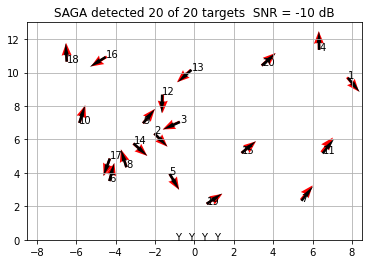

In [25]:
print ('{} detected {} of {} targets in {}s with sensor observations:{}.'.format(cfg.mode, len(min_gsigs),Nob, round(sum(runtime),2),[len(garda.r) for garda in garda_sel]))
print('=== Association complexity (graph edges evaluated) ===')
print('Brute Force search (All edges) \t=\t{}'.format(Total_edges))
print('Geometric constraint pruning \t=\t{}'.format(assoc_time[0]))
print('{} association algorithm \t=\t{}'.format(assoc_algo, assoc_time[1]))
plt.figure(13)
for gtr in min_gsigs:
    dob = gtr.state_end.mean
    plt.quiver(dob[0], dob[1], dob[2], dob[3],color='r', headwidth = 4)
pr.plot_scene(plt, scene, sensors, 13, '{} detected {} of {} targets  SNR = {} dB'.format(assoc_algo,len(min_gsigs), Nob, round(snr)))